Marcin Wardyński
czwartek, 8:00

## Lab3 - Levensthein

Załadujmy FIQA razem z relacjami

In [1]:
from datasets import load_dataset

fiqa_corpus = load_dataset("clarin-knext/fiqa-pl", name="corpus")
fiqa_queries = load_dataset("clarin-knext/fiqa-pl", name="queries")
fiqa_qrels = load_dataset("clarin-knext/fiqa-pl-qrels")

/Users/mwardynski/Documents/ds/_semestr_9/przetwarzanie_jezyka_naturalnego/labs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Stokenizujmy korpus używając SpaCy i obliczmy listy frekwencji każdego z wyrazów.  
Wylistujmy stworzoną listę frekwencji, przy się nam później do odpowiedzi na pytanie o rozkład słow w korpusie.

In [2]:
from spacy.tokenizer import Tokenizer
from spacy.lang.pl import Polish
from collections import Counter
import re

nlp = Polish()
tokenizer = Tokenizer(nlp.vocab)

clean_token_pattern = re.compile(r"\W|\d|_")

texts = fiqa_corpus['corpus']['text'] + fiqa_queries['queries']['text']

token_counter = Counter()
for doc in tokenizer.pipe(texts, batch_size=500):
    for token in doc:
        cleaned_token = clean_token_pattern.sub("", token.text)
        if cleaned_token:
            token_counter[cleaned_token.lower()] += 1

token_counter

Counter({'w': 177313,
         'nie': 132154,
         'i': 126963,
         'na': 120492,
         'to': 116453,
         'z': 98189,
         'jest': 94338,
         'że': 90150,
         'się': 86403,
         'do': 67205,
         'jeśli': 52121,
         'a': 41506,
         'ale': 41325,
         'o': 38510,
         'są': 35946,
         'jak': 34795,
         'lub': 32862,
         'za': 32725,
         'aby': 31263,
         'od': 30211,
         'co': 30207,
         'może': 26590,
         'dla': 25950,
         'po': 25902,
         'tak': 25684,
         'które': 24100,
         'możesz': 23366,
         'czy': 22244,
         'tego': 21982,
         'tym': 21659,
         'ma': 20417,
         'być': 19355,
         'ponieważ': 18952,
         'przez': 17973,
         'tylko': 17347,
         'usd': 17257,
         'więc': 17081,
         'niż': 16946,
         'ich': 14669,
         'pieniądze': 14131,
         'więcej': 13928,
         'gdy': 13681,
         'jako': 131

Tworzymy funkcję wprowadzającą zmianę o odległości 1 w skali Levenstheina w pojedyńczym słowie z wprowadzonego zdania, a następnie aplikujemy tą funkcję do listy `queries` ze zbioru FIQA-PL.

In [3]:
import random
import string

def distort_token(token):
    word = token.text
    idx = random.randint(0, len(word) - 1)
    
    distortion_type = random.randint(0, 2)
    new_word = word
    if distortion_type == 0 and len(word) > 1:
        new_word =  word[:idx] + word[idx + 1:]
    elif distortion_type == 1:
        random_letter = random.choice(string.ascii_lowercase)
        new_word = word[:idx] + random_letter + word[idx:]
    elif distortion_type == 2:
        random_letter = random.choice(string.ascii_lowercase)
        new_word =  word[:idx] + random_letter + word[idx + 1:]
    return new_word

def distort_query_tokens(query):
    doc = tokenizer(query)
    tokens = list(doc)
    
    token_idx = random.randint(0, len(tokens) - 1)
    distorted_token = distort_token(tokens[token_idx])
    
    tokens[token_idx] = distorted_token
    return " ".join(str(token) for token in tokens)


distorted_queries_text = [distort_query_tokens(query) for query in fiqa_queries['queries']['text']]

Przkonwertujmy zmienione zapytania do typu dataset i sprawdźmy, jak wyglądają wprowadzone zmiany.

In [4]:
distorted_queries = fiqa_queries['queries'].map(lambda x, idx: {"text": distorted_queries_text[idx]}, with_indices=True)
distorted_queries['text']

Map: 100%|██████████| 6648/6648 [00:00<00:00, 35994.34 examples/s]


['Co jest uważane z wydatek służbowy w podróży służbowej?',
 'Wydatki służbwe - ubezpieczenie samochodu podlegające odliczeniu za wypadek, który wydarzył się podczas podróży służbowej',
 'Rozpoczęcie nowego biznesu tnline',
 '„Dzień roboczy” i „termin płatności” ruachunków',
 'Nowy właściciel firmy – xak działają podatki dla firmy i osoby fizycznej?',
 'Hobby krontra biznes',
 'Czeki osobiste zamsiast firmowych',
 'Czy amerykański kodeks podatkowy wymaga, aby właściciele małyh firm liczyli zakupy biznesowe jako dochód osobisty?',
 'Jak mogę zarejestrować firmę w Wielkiej Brytanii bez podawania adresu fvirmy?',
 'Czym są „podstawy bhznesowe”?',
 'Strata cna inwestycjach biznesowych z poprzedniego roku',
 'Jak mogę oszacować podatki biznesowe / opłaty za zgłowszenie dla firmy, która ma 0 USD dochodu?',
 'Czy zakup samochodu dla firmy za pomocą kredytu biznesowego zostałby unany za wydatek biznesowy?',
 'Odliczanie strat biznesowych z gostatnich lat (nieudokumentowanych)',
 '30% udziału b

Konfigurujemy indeks w uruchomionej uprzedmio instacji Elasticsearch. Ponieważ mieliśmy pozostać możliwie wierni operacjom z poprzedniego laboratorium, indeks zawiera filtr morfologiczny.  
Brak jego użycia obniżył znacznie metrykę NDCG@5, więc w tym ćwiczeniu zostaje na miejscu.

In [5]:
es_url = "http://localhost:9200"
index_name = "mw_nlp_lab3"

index_url = F"{es_url}/{index_name}"

import requests

delete_response = requests.delete(f"{index_url}")
if delete_response.status_code == 200:
    print(f"Index '{index_name}' deleted successfully.")
else:
    print(f"Failed to delete index '{index_name}': {delete_response.text}")

import json

fiqa_index_settings = {
    "settings": {
        "analysis": {
            "filter": {
                "polish_morfologik": {
                    "type": "morfologik_stem"
                }
            },
            "analyzer": {
                "polish_analyzer_morf": {
                    "type": "custom",
                    "tokenizer": "standard",
                    "filter": [
                        "lowercase",
                        "polish_morfologik",
                        "lowercase"
                    ]
                }
            }
        }
    },
    "mappings": {
        "properties": {
        "text": {
            "type": "text",
            "analyzer": "polish_analyzer_morf"
            }
        }
    }
}

response = requests.put(index_url, headers={"Content-Type": "application/json"}, data=json.dumps(fiqa_index_settings))
if response.status_code == 200:
    print("Index created.")
else:
    print(f"Index creation failed: {response.text}")



Index 'mw_nlp_lab3' deleted successfully.
Index created.


Ładujemy dane w batchu do stworzonego indeksu.

In [6]:
def bulk_load(dataset):
    bulk_data = ""
    for entry in dataset["corpus"]:
        doc_id = entry["_id"]
        bulk_data += json.dumps({"index": {"_index": index_name, "_id": doc_id}}) + "\n"
        bulk_data += json.dumps({"text": entry['text']}) + "\n"



    bulk_response = requests.post(f"{es_url}/_bulk", headers={"Content-Type": "application/x-ndjson"}, data=bulk_data)

    if bulk_response.status_code == 200:
        response_data = bulk_response.json()
        if any(item.get("index", {}).get("error") for item in response_data["items"]):
            print("Some documents failed to index:")
            for item in response_data["items"]:
                if "error" in item["index"]:
                    print(item["index"]["error"])
        else:
            print("All documents indexed successfully.")
    else:
        print(f"Failed to index data: {bulk_response.text}")

bulk_load(fiqa_corpus)

All documents indexed successfully.


Następnie budujemy struktury pomocnicze na potrzeby obliczania NDCG@10.

In [7]:
def prepare_fiqa_qrels():
    query_to_corpus_dict = {}

    subsets = ['test', 'validation', 'train']

    for subset in subsets:
        for item in fiqa_qrels[subset]:
            if item['query-id'] not in query_to_corpus_dict:
                query_to_corpus_dict[item['query-id']] = {}

            query_to_corpus_dict[item['query-id']][item['corpus-id']] = item['score']

    for query_id in query_to_corpus_dict:
        sorted_corpuses_by_score = dict(sorted(query_to_corpus_dict[query_id].items(), key=lambda item: item[1]))
        query_to_corpus_dict[query_id] = sorted_corpuses_by_score

    return query_to_corpus_dict

def prepare_existing_fiqa_queries(query_to_corpus_dict):
    queries_dict = {}

    queries_dataset = fiqa_queries['queries']
    for entry in queries_dataset:
        if int(entry['_id']) in query_to_corpus_dict.keys():
            queries_dict[int(entry['_id'])] = entry['text']

    return queries_dict


query_to_corpus_dict = prepare_fiqa_qrels()
queries_dict = prepare_existing_fiqa_queries(query_to_corpus_dict)

Tworzymy funkcę do odpytywania indeksu, pozwalająca skorzystanie z `fuzzy-search` lub nie.

In [8]:
dcg_limit = 10

def find_for_phrase(search_phrase, search_field, custom_analyzer, fuzzy):
    search_query = {
        "size": dcg_limit,
        "query": {
            "match": {
                search_field: {
                    "query": search_phrase,
                    "fuzziness": 'AUTO' if fuzzy else 0
                }
            }
        }
    }

    if custom_analyzer:
        search_query['query']['match'][search_field]['analyzer'] = custom_analyzer

    response = requests.get(f"{index_url}/_search", headers={"Content-Type": "application/json"}, data=json.dumps(search_query))

    if response.status_code == 200:
        search_results = response.json()
        return dict(list(map(lambda hit: (int(hit['_id']), float(hit['_score'])), search_results["hits"]["hits"])))
    else:
        print(f"Search failed: {response.text}")

Ostatecznie definiujemy funkcję obliczającą NDCG@10 oraz prezentującą uzyskane wyniki na wykresach.

In [9]:
import math

relevant_doc_number = 0
relevant_docs = []

def calculate_dcg(docs, docs_scoring):
    sum = 0
    relevant_doc_id = None
    for i, doc_id in enumerate(docs):
        if doc_id in docs_scoring.keys():
            sum += (2**docs_scoring[doc_id]-1)/(math.log2(i+1+1))
            if i == relevant_doc_number:
                relevant_doc_id = doc_id
    return sum, relevant_doc_id

def calculate_ndcgs(queries, search_field, custom_analyzer, fuzzy):
    
    ndcgs = []

    for query in queries:
        q_id = int(query['_id'])
        q_text = query['text']
        if(q_id not in queries_dict.keys()):
            continue
        ideal_search = list(query_to_corpus_dict[q_id].keys())[:dcg_limit]
        idcg, _ = calculate_dcg(ideal_search, query_to_corpus_dict[q_id])

        real_search_with_scores = find_for_phrase(q_text, search_field, custom_analyzer, fuzzy)
        dcg, relevant_doc_id = calculate_dcg(real_search_with_scores.keys(), query_to_corpus_dict[q_id])

        ndcgs.append(dcg/idcg)

        if relevant_doc_id:
            relevant_docs.append((relevant_doc_id, real_search_with_scores[relevant_doc_id], real_search_with_scores.values(), q_text))

    return ndcgs

import matplotlib.pyplot as plt
import numpy as np
def present_results(ndcgs):

    zeros = []
    non_zeros = []

    for ndcg in ndcgs:
        if ndcg == 0:
            zeros.append(ndcg)
        else:
            non_zeros.append(ndcg)

    labels = ['>0 Results', '0 Results']
    sizes = [len(non_zeros), len(zeros)]

    plt.pie(sizes, labels=labels, autopct='%1.1f%%')
    plt.title('NDCG@10 Results Proportion: 0 to >0')
    plt.show()

    plt.hist(non_zeros, bins=10, edgecolor='black')
    plt.title("Histogram of Non-Zero NDCG@10")
    plt.xlabel("Score")
    plt.ylabel("Number of Documents")
    plt.show()

    print(f"NDCG@10 Mean: {np.mean(ndcgs)} and Std: {np.std(ndcgs)}")
    print(f"NDCG@10 > 0 Mean: {np.mean(non_zeros)} and Std: {np.std(non_zeros)}")



W pierwszej kolejności mierzymy metrykę NDCG@10 dla zapytań zawierających błąd.

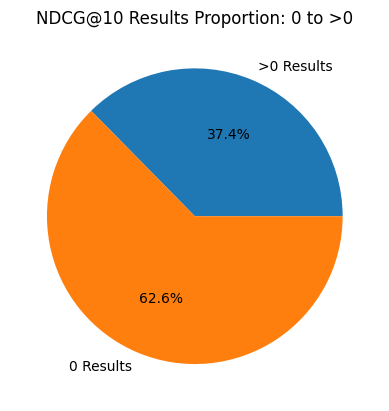

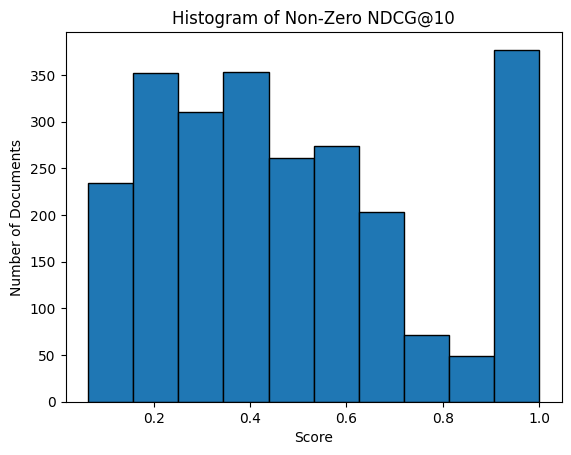

NDCG@10 Mean: 0.18446073733486856 and Std: 0.2932164358431634
NDCG@10 > 0 Mean: 0.4936775289058801 and Std: 0.2782917747937624


In [10]:
ndcgs = calculate_ndcgs(distorted_queries, 'text', '', False)
present_results(ndcgs)

Teraz przygotowujemy listę słów występujących w języku polskim na podstawie słownika Morfeusz.

In [11]:
def read_morfeusz_into_set(file_path):
    correct_words = set()

    with open(file_path, "r", encoding="utf-8") as file:
        for line_number, line in enumerate(file):
            if line_number < 31:
                continue
            word = line.split("\t")[0]
            correct_words.add(word.lower())
    return correct_words

correct_words = read_morfeusz_into_set("morfeusz/polimorf-20241117.tab")
len(correct_words)


5348627

Tworzymy również funkcję poprawiającą slowa z literówką na podstawie wczytanego uprzednio słownika oraz list frekwencji wyrazów.

Funkcja nie skanuje całego słownika, lecz wprowadza wszystkie dopuszczalne zmiany we wczytanym słowie i dopiero z tak przygotowanej listy wybiera słowo istniejące w słowniku, które w danym korpusie występuje najczęściej.

Implementacja w dużeje mierze czerpie z podlinkowanego w poleceniu artykułu: https://norvig.com/spell-correct.html

In [12]:
import re

def split_to_words(text): return re.findall(r'\w+', text)

def P(word, N=sum(token_counter.values())): 
    "Probability of `word`."
    return token_counter[word] / N

def correct(word): 
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word))  or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in correct_words)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyzęóąśłżźćń'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)


Funkcja poprawiająca podane na wejściu zapytanie używając zdefiniowanej powyżej funkcji opartej na odległości Levenstheina. Używamy jej do napriawienia wszystkich zaburzonych uprzednio zapytań.

In [13]:
skip_word_pattern = re.compile(r"(\d|_)+")

def correct_queries_text(query):
    words = split_to_words(query)
    corrected_query = query
    for word in words:
        low_word = word.lower()
        if low_word not in correct_words:
            if skip_word_pattern.match(low_word):
                continue
            corrected_word = correct(low_word)
            corrected_query = corrected_query.replace(word, corrected_word)
    return corrected_query    
            

corrected_queries_text = [correct_queries_text(query) for query in distorted_queries['text']]

Poniżej widzimy, w jaki sposób zapytania zostały poprawione.

In [14]:
corrected_queries = distorted_queries.map(lambda x, idx: {"text": corrected_queries_text[idx]}, with_indices=True)
corrected_queries['text']

Map: 100%|██████████| 6648/6648 [00:00<00:00, 9162.38 examples/s]


['Co jest uważane z wydatek służbowy w podróży służbowej?',
 'Wydatki służbowe - ubezpieczenie samochodu podlegające odliczeniu za wypadek, który wydarzył się podczas podróży służbowej',
 'Rozpoczęcie nowego biznesu online',
 '„Dzień roboczy” i „termin płatności” rachunków',
 'Nowy właściciel firmy – jak działają podatki dla firmy i osoby fizycznej?',
 'Hobby kontra biznes',
 'Czeki osobiste zamiast firmowych',
 'Czy amerykański kodeks podatkowy wymaga, aby właściciele małych firm liczyli zakupy biznesowe jako dochód osobisty?',
 'Jak mogę zarejestrować firmę w Wielkiej Brytanii bez podawania adresu firmy?',
 'Czym są „podstawy biznesowe”?',
 'Strata cna inwestycjach biznesowych z poprzedniego roku',
 'Jak mogę oszacować podatki biznesowe / opłaty za zgłoszenie dla firmy, która ma 0 USD dochodu?',
 'Czy zakup samochodu dla firmy za pomocą kredytu biznesowego zostałby znany za wydatek biznesowy?',
 'Odliczanie strat biznesowych z ostatnich lat (nieudokumentowanych)',
 '30% udziału bw bi

Mierzymy NDCG@10 dla poprawionych zapytań:

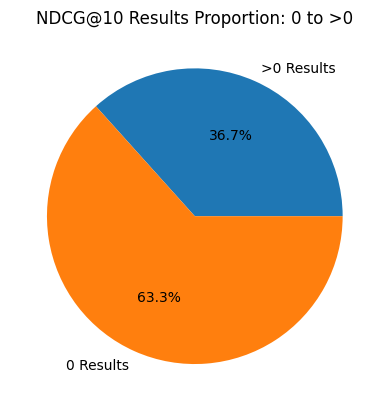

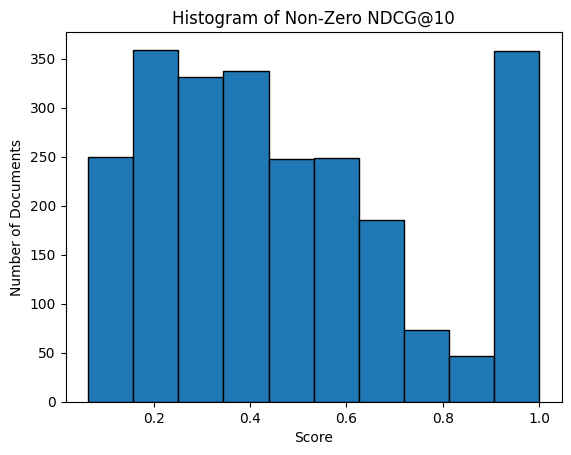

NDCG@10 Mean: 0.17710868403719437 and Std: 0.2878356726573323
NDCG@10 > 0 Mean: 0.48314260626970384 and Std: 0.2795540076582474


In [15]:
ndcgs = calculate_ndcgs(corrected_queries, 'text', '', False)
present_results(ndcgs)

A także NDCG@10 w przypadku użycia zaburzonych zapytań, lecz z użyciem `fuzzy-search` w trakcie formułowania zapytania do indeksu:

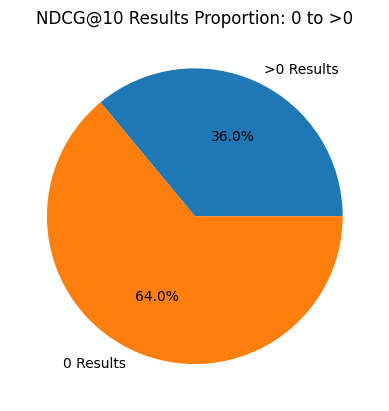

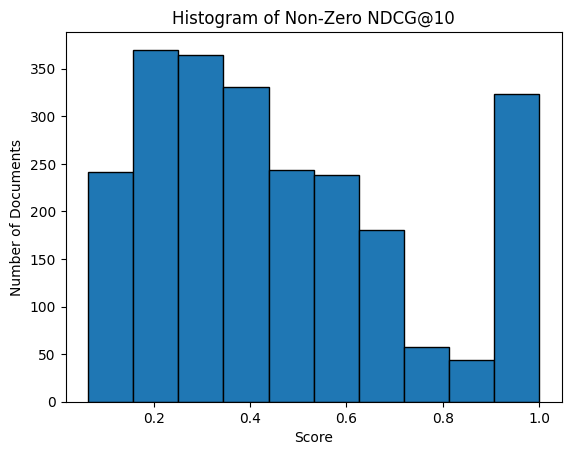

NDCG@10 Mean: 0.16962379525703433 and Std: 0.27931967279568753
NDCG@10 > 0 Mean: 0.4710355016160251 and Std: 0.27327638613252037


In [16]:
ndcgs = calculate_ndcgs(distorted_queries, 'text', '', True)
present_results(ndcgs)

Następnie prosimy o korektę podzioru zapytań przez LLM.

Poniżej pierwszych 30 z błędem, poprawionych przez naszą funkcję oraz poprawionych przez LLM, wylisotwane zachowując tą kolejność. (Poprawa LLM została wykonana przez ChatGPT-4, dnia 23.11.2024)

1. Co jest uważane za wydatek służbowy w **podrójy** służbowej?  
    Co jest uważane za wydatek służbowy w **podróży** służbowej?  
    Co jest uważane za wydatek służbowy w **podróży** służbowej?
    

2. Wydatki służbowe - ubezpieczenie samochodu podlegające odliczeniu za wypadek, który wydarzył się podczas podróży **słżbowej**  
    Wydatki służbowe - ubezpieczenie samochodu podlegające odliczeniu za wypadek, który wydarzył się podczas podróży **służbowej**  
    Wydatki służbowe - ubezpieczenie samochodu podlegające odliczeniu za wypadek, który wydarzył się podczas podróży **służbowej**.
    
    
3. Rozpoczęcie nowego biznesu **onlaine**  
    Rozpoczęcie nowego biznesu **online**  
    Rozpoczęcie nowego biznesu **online**.

4. „Dzień roboczy” i „termin płatności” **jrachunków**  
    „Dzień roboczy” i „termin płatności” **rachunków**  
    „Dzień roboczy” i „termin płatności” **rachunków**.

5. Nowy właściciel firmy – Jak **dziłają** podatki dla firmy i osoby fizycznej?  
    Nowy właściciel firmy – Jak **działają** podatki dla firmy i osoby fizycznej?  
    Nowy właściciel firmy – Jak **działają** podatki dla firmy i osoby fizycznej?

6. Hobby kontra **biiznes**  
    Hobby kontra **biznes**  
    Hobby kontra **biznes**.
    

7. Czeki osobiste zamiast **fgrmowych**  
    Czeki osobiste zamiast **firmowych**  
    Czeki osobiste zamiast **firmowych**.

8. **zy** amerykański kodeks podatkowy wymaga, aby właściciele małych firm liczyli zakupy biznesowe jako dochód osobisty?  
    **z** amerykański kodeks podatkowy wymaga, aby właściciele małych firm liczli zakupy biznesowe jako dochód osobisty?  <- poprawny wyraz, lecz zdanie bez sensu  
    **Czy** amerykański kodeks podatkowy wymaga, aby właściciele małych firm liczyli zakupy biznesowe jako dochód osobisty?

9. Jak mogę zarejestrować firmę w Wielkiej Brytanii bez podawania adresu **firamy**?  
    Jak mogę zarejestrować firmę w Wielkiej Brytanii bez podawania adresu **firmy**?  
    Jak mogę zarejestrować firmę w Wielkiej Brytanii bez podawania adresu **firmy**?

10. Czym są „**podstaw** biznesowe”?  
    Czym są „**podstaw** biznesowe”? <- słówko istnieje, więc bez poprawy, ale zdanie niepoprawne  
    Czym są „**podstawy** biznesowe”?


11. **oStrata** na inwestycjach biznesowych z poprzedniego roku  
    **strata** na inwestycjach biznesowych z poprzedniego roku  
    **Strata** na inwestycjach biznesowych z poprzedniego roku.

12. Jak mogę oszacować podatki biznesowe / opłaty za zgłoszenie dla firmy, która ma 0 USD **dochou**?  
    Jak mogę oszacować podatki biznesowe / opłaty za zgłoszenie dla firmy, która ma 0 USD **dochodu**?  
    Jak mogę oszacować podatki biznesowe/opłaty za zgłoszenie dla firmy, która ma 0 USD **dochodu**?

13. Czy zakup samochodu dla **fidmy** za pomocą kredytu biznesowego zostałby uznany za wydatek biznesowy?  
    Czy zakup samochodu dla **firmy** za pomocą kredytu biznesowego zostałby uznany za wydatek biznesowy?  
    Czy zakup samochodu dla **firmy** za pomocą kredytu biznesowego zostałby uznany za wydatek biznesowy?

14. Odliczanie strat biznesowych z ostatnich **lau** (nieudokumentowanych)  
    Odliczanie strat biznesowych z ostatnich **lau** (nieudokumentowanych) <- słowo nie zostało poprawione  
    Odliczanie strat biznesowych z ostatnich **lat** (nieudokumentowanych).

15. 0% udziału w biznesie  <- brak modyfikacji  
    0% udziału w biznesie  
    0% udziału w biznesie.

16. Odbieranie wydatków służbowych **h** osobistej karty kredytowej  
    Odbieranie wydatków służbowych ***h** osobistej karty kredytowej <- słówko niepoprawione  
    Odbieranie wydatków służbowych **z** osobistej karty kredytowej.

17. Używanie czeku biznesowego do płatności w handlu **detaalicznym**  
    Używanie czeku biznesowego do płatności w handlu **detalicznym**  
    Używanie czeku biznesowego do płatności w handlu **detalicznym**.


18. Podatek przy zakładaniu firmy **hw** pełnym wymiarze czasu pracy  
    Podatek przy zakładaniu firmy **w** pełnym wymiarze czasu pracy <- słówko niepoprawione  
    Podatek przy zakładaniu firmy **w** pełnym wymiarze czasu pracy.
    
19. Czy mogę spłacić saldo karty **kredytwej**, aby zwolnić dostępny kredyt?  
    Czy mogę spłacić saldo karty **kredytowej**, aby zwolnić dostępny kredyt?  
    Czy mogę spłacić saldo karty **kredytowej**, aby zwolnić dostępny kredyt?

20. Powolne **roxzpoczynanie** działalności pobocznej  
    Powolne **rozpoczynanie** działalności pobocznej  
    Powolne **rozpoczynanie** działalności pobocznej.

21. Dlaczego **rspieniężanie** czeków” jest legalną działalnością? <- trudne, zastąpienie cudzysłowu przez literę  
    Dlaczego **spieniężanie** czeków” jest legalną działalnością? <- słówko poprawione, ale cudzysłów nieuzupełniony
    Dlaczego **„spieniężanie** czeków” jest legalną działalnością?

22. **Cy** biznes to jedyny sposób na zostanie milionerem?  
    **co** biznes to jedyny sposób na zostanie milionerem? <- słówko poprawne, lecz niewłaściwe dla reszty zdania  
    **Czy** biznes to jedyny sposób na zostanie milionerem?
    
23. Wycenianie małej firmy, w **któr** warto zainwestować  
    Wycenianie małej firmy, w **które** warto zainwestować <- niewłaściwa odmiana, ale słowo poprawne  
    Wycenianie małej firmy, w **którą** warto zainwestować.

24. Rozpoczęcie **dużeeo** biznesu z niezbyt dużymi dochodami  
    Rozpoczęcie **dużego** biznesu z niezbyt dużymi dochodami?  
    Rozpoczęcie **dużego** biznesu z niezbyt dużymi dochodami.

25. Wymagania dotyczące **rczliczania** podatków biznesowych?  
    Wymagania dotyczące **rozliczania** podatków biznesowych?  
    Wymagania dotyczące **rozliczania** podatków biznesowych.

26. IRA **d** pracy i mojej firmy  
    IRA **d** pracy i mojej firmy  <- pojedyńcza litera nie została poprawiona  
    IRA **dla** pracy i mojej firmy. <- rózne od oryginału, lecz poprawne

27. Doradztwo w zakresie **turansferu** pieniędzy  
    Doradztwo w zakresie **transferu** pieniędzy  
    Doradztwo w zakresie **transferu** pieniędzy.

28. Jak przenieść leasing samochodu osobistego do **leasinzu** samochodu biznesowego?  
    Jak przenieść leasing samochodu osobistego do **leasingu** samochodu biznesowego?  
    Jak przenieść leasing samochodu osobistego do **leasingu** samochodu biznesowego?

29. Korepetycje z zarządzania **płacanmi** biznesowymi  
    Korepetycje z zarządzania **płacami** biznesowymi  
    Korepetycje z zarządzania **płacami** biznesowymi.

30. Czy **jtako** właściciel małej firmy powinienem płacić podatki z mojego osobistego lub firmowego konta czekowego?  
    Czy **jako** właściciel małej firmy powinienem płacić podatki z mojego osobistego lub firmowego konta czekowego?  
    Czy **jako** właściciel małej firmy powinienem płacić podatki z mojego osobistego lub firmowego konta czekowego?


Wnioski po wykonaniu ćwiczenia na temat:

#### 1. Rozkładu słów w korpusie:

    Przeglądając listy frekwencji można zauważyć dominującą liczbę następujących części mowy:
    - przyimki: w, na, z...
    - spójniki: i, że, czy, lub, aby
    - partykuły: nie, czy, tylko
    - zaimki: się, co, które

    Występują również czasowniki, rzeczowniki, przymiotniki itp. lecz są one znacznie rzadsze od wspomnianych powyżej części mowy, więc plasują się odpowiednio niżej. Nielicznymi wyjątkami wśród czasowników są: są, może, być.

    Obserwacja występujących form mowy jest bardzo ważna dla jakości wyników w metryce NDCG@10. Widząc tak odległe miejsca części mowy jak rzeczowniki, czasowniki, czy też przymiotniki, ktore to niosą więkoszość informacji na temat naszego zapytania, nie dziwi fakt, że skuteczność dopasowanych wyników jest dość niska, gdyż odnalezione zostanie mnóstwo dokumentów pasujących poprzez formach mowy typu przyimek, spójnik, partykuła. Są one dość częste, lecz nie niosą ze sobą dużo istotnej informacji.

    Podobnie jak w poprzednim ćwiczeniu, również i tym razem wskazuję, że wprowadzenie filtra typu `stopwords` mogłoby w znacznym stopniu poprawić jakość dopasowań zwracanych przez indeks.

#### 2. Szybkość wykonania zapytań:

Porównanie wydajności wykonam dla dwóch przypadków,  w każym z nich zmierzę czas sumaryczny dla wszystkich wywołań Elasticsearch, których jest tyle, ile krotek w zbiorze `queries` FIQA-PL.
- lolakla poprawa zapytań z użyciem funkcji opartej o odległość Levenstheina + zapytanie o bezpośrednie dopasowanie do Elasticsearch z filtrem morfologik: 0:01 + 1:05 = 1:06
- zapytanie z zastosowaniem `fuzzy-search` do Elasticsearch z filtrem morfologik bez uprzedniej poprawy zapytań zawierających błędy: 3:54

Jak widać zapytanie z użyciem `fuzzy-search` potrzebuje niemalże cztery razy więcej czasu od lokalnej korekcji wyrażeń i zapytania z dopasowaniem bezpośrednim.

Dodam jeszcze tylko, że w sumie wszystkich zapytań do Elasticsearch w każdym z podpunktów jest 6648, a więc na pojedyńcze zapytanie potrzeba odpowiednio <0.01s i 0.035, a więc w obydwu przypadkach odpowiedź na pojedyńcze zapytanie do serwera jest zwracana w zaniedbywalnym dla ludzkiej percepcji.

#### 3. Jakość uzyskanych wyników:

Jakość wyników pokazuje bardzo ciekawą zależność, a mianowicie że poprawa literówek w zapytaniu doprowadziła do obniżenia wartości metryki NDCG@10, i to dla obydwu podejść. Widzę dla tego stanu rzeczy następujące wyjaśnienie:

- przy korekcji funkcją lokalną i zapytaniu z dopasowaniem bezpośrednim:  
    opierając się na rozkładzie form mowy w zbiorze, który to pokazuje na znaczną przewagę wyrazów nie wnoszących istotnych informacji, wprowadzenie literów w dużej mierze musiało również dotyczyć takich właśnie słabych jakościowo wyrazów, przez co bezpośrednie dopasowanie nie uwzględniało ich i niejako automatycznie pozostałe wyrazy, w tym te o dużej istotności dla wyszukiwanej frazy, nabierały większego znaczenia.  
    Poprawa literów przyniosłaby zapewne znaczą poprawę przy bezpośrednim dopasowaniu, gdyby wcześniej zestaw danych został lepiej przygotowany i nie zawierał mało wnoszących wyrazów.

- przy zastosowaniu zapytania z `fuzzy-search`:
    w tym przypadku korekrcja nie obejmuje tylko jednego wyrazu, a wszystkich wyrazów z zapytania, a co więcej przy dłuższych wyrazach może ona dopuszczać odległość Levenstheina > 1. Przy takim podejściu mnóstwo słówek podobnych do tych wyszukiwanych, również zostaje zaakceptowanych, przez co dokładają się do zaburzenia zwracanych wyników.  
    Generalnie dobrą praktyką jest wprowadzenie boostingu, czyli swojego rodzaju wag, które to wyżej oceniają bezpośrednia dopasowania, niżej natomiast dopasowania typu `fuzzy`. W poleceniu była prośba o zastosowanie zapytań `fuzzy`, stąd nie zaaplikowałem tej zasady.  
    Poza tym, tak jak i w poprzednim punkcie, lepsze odfiltrowanie mało znaczących słów znacznie poprawiłoby nasze wyniki.

Generalnie należy jeszcze zauważyć, że te różnice w wartości NDCG@10 między zapytaniami z wyrażeniami zawierającymi literówki, a dwoma metodami radzenia sobie z nimi są dość małe. Poza tym jedynie 36-37% wszystkich zapytań nie otrzymało wartości 0 w NDCG@10, a średnia wśród tych wyników to 0.48 +/-0.01, czyli dość kiepsko.  
Wszystko to wskazuje na zdecydowaną potrzebę lepszego przygotowania danych do wyszukiwania.

#### 4. Poprawność wprowadzonych korekcji:

#### 5. Możliwości LLM w zakresie poprawy pisowni: